# Computational Social Science Project #2 

**Enter your Name:** Julian Vargo, Niko Schwarz, Riley VanMeter, Regina Ebo

*Semester:* Fall 2023


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [2]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv('Diabetes with Population Info by County 2017.csv', 
                       dtype={"CountyFIPS": str}) 
diabetes.head

<bound method NDFrame.head of                  County    State CountyFIPS Diabetes_Number Obesity_Number  \
0        Autauga County  Alabama      01001            5178          13489   
1        Baldwin County  Alabama      01003           16707          48542   
2        Barbour County  Alabama      01005            3400           8009   
3           Bibb County  Alabama      01007            2371           6534   
4         Blount County  Alabama      01009            6282          14227   
...                 ...      ...        ...             ...            ...   
3215  Sweetwater County  Wyoming      56037            2560           9362   
3216       Teton County  Wyoming      56039             439           2051   
3217       Uinta County  Wyoming      56041            1440           4925   
3218    Washakie County  Wyoming      56043             637           1738   
3219      Weston County  Wyoming      56045             601           2015   

     Physical_Inactivity_Number  

In [3]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape:', diabetes.shape)

shape: (3220, 95)


In [4]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [5]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [6]:

#
# Now do the same as above, but for "Obesity_Number"
#-----------

print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique()) 

['No Data']


In [7]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------

print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique()) 

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [8]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 


# Physical Inactivity
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 


# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [9]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce')

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)


Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [10]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [11]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_one race_1',
 'sex and age_total population_18 years and over_1',
 'sex and age_total population_65 years and over_1',
 'race_total population_two or more races_1',
 'hispanic or latino and race_total population',
 'sex and age_total population']

In [12]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=['race_total population_two or more races_1',
 'race_total population_one race_1',
 'hispanic or latino and race_total population',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population_18 years and over_1',
 'sex and age_total population'])

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [13]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

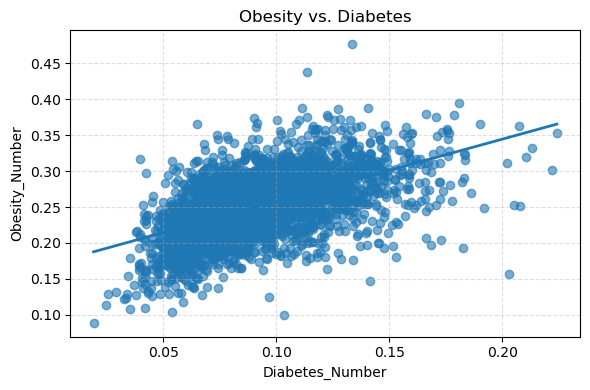

In [14]:
# EDA #1 and interpretations in this section 
#-----------

import numpy as np
import matplotlib.pyplot as plt

# 1) Select and clean the data
df = diabetes[['Diabetes_Number', 'Obesity_Number']].copy()
df = df.replace([np.inf, -np.inf], np.nan).dropna()

X = df['Diabetes_Number'].to_numpy()
y = df['Obesity_Number'].to_numpy()

# 2) Scatter plot
plt.figure(figsize=(6,4))
plt.scatter(X, y, alpha=0.6)
plt.xlabel('Diabetes_Number')
plt.ylabel('Obesity_Number')
plt.title('Obesity vs. Diabetes')

# 3)regression line (simple linear fit)
m, b = np.polyfit(X, y, 1)        # slope and intercept
x_line = np.linspace(X.min(), X.max(), 200)
y_line = m * x_line + b
plt.plot(x_line, y_line, linewidth=2)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


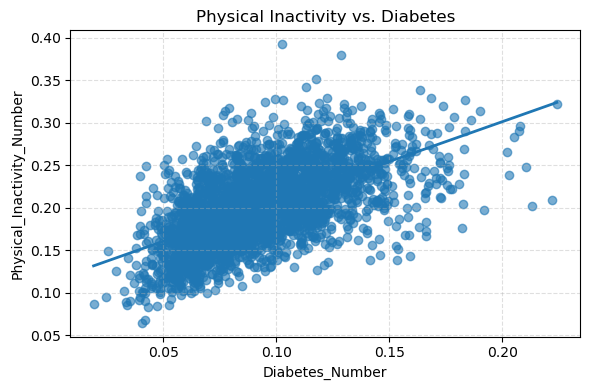

In [15]:
#
# EDA #2 and interpretations in this section 
#-----------
# EDA #1 and interpretations in this section 
#-----------

import numpy as np
import matplotlib.pyplot as plt

# 1) Select and clean the data
df = diabetes[['Diabetes_Number', 'Physical_Inactivity_Number']].copy()
df = df.replace([np.inf, -np.inf], np.nan).dropna()

X = df['Diabetes_Number'].to_numpy()
y = df['Physical_Inactivity_Number'].to_numpy()

# 2) Scatter plot
plt.figure(figsize=(6,4))
plt.scatter(X, y, alpha=0.6)
plt.xlabel('Diabetes_Number')
plt.ylabel('Physical_Inactivity_Number')
plt.title('Physical Inactivity vs. Diabetes')

# 3)regression line (simple linear fit)
m, b = np.polyfit(X, y, 1)        # slope and intercept
x_line = np.linspace(X.min(), X.max(), 200)
y_line = m * x_line + b
plt.plot(x_line, y_line, linewidth=2)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [16]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ["Region"],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [17]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(columns=['Diabetes_Number', "race alone or in combination with one or more other races_total population"]) 

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. ##After investigating, we've decided not to remove any features. We already removed features above and want to see what comes up as relevant after running the models. 

In [18]:
#
# Feature selection
#-----------

X.head()

,CountyFIPS,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race - and three or more races,total housing units,citizen - voting age population_citizen - 18 a

In [19]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.80,      # specify proportional split for training
                                                    test_size=0.20)       # specify proportional split for test

In [20]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,         # specify training x
                                                            y_train,         # specify training y
                                                            train_size=0.75, # set training proportional spilt
                                                            test_size=0.25)  # set testing proportional split

In [21]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** ...

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  (enter name of model here) 

In [22]:
#
# Model 1 training
#-----------
#load libs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

# print model coefficients and intercept
#print(lin_model.coef_)
#print(lin_model.intercept_)

# create a dataframe with the coefficient and feature names for plotting
lin_reg_data = pd.DataFrame([lin_model.coef_, X.columns]).T # make a dataframe from the arrays
lin_reg_data.columns = ['Coefficient', 'Feature']           # add column names for clarity

print(lin_reg_data)


   Coefficient                                            Feature
0         -0.0                                         CountyFIPS
1      0.00808                                     Obesity_Number
2     0.007199                         Physical_Inactivity_Number
3     0.003247  sex and age_total population_65 years and over...
4     0.000333                              race_total population
5    -0.004914                     race_total population_one race
6     0.004914            race_total population_two or more races
7    -0.048586               race_total population_one race_white
8     0.043938  race_total population_one race_black or africa...
9     0.016148  race_total population_one race_american indian...
10    0.001149  race_total population_one race_american indian...
11   -0.000077  race_total population_one race_american indian...
12    0.000668  race_total population_one race_american indian...
13    0.001325  race_total population_one race_american indian...
14    0.01

#### Model 2:  (enter name of model here) 

In [23]:
#
# Model 2 training
#-----------

# create a model
lasso_reg = Lasso(max_iter=15000)  # note the hypterparameter tuning will not converge with max_iter < 15000
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity

print(lasso_reg_data)


   Coefficient                                            Feature
0         -0.0                                         CountyFIPS
1          0.0                                     Obesity_Number
2          0.0                         Physical_Inactivity_Number
3         -0.0  sex and age_total population_65 years and over...
4         -0.0                              race_total population
5          0.0                     race_total population_one race
6         -0.0            race_total population_two or more races
7         -0.0               race_total population_one race_white
8          0.0  race_total population_one race_black or africa...
9          0.0  race_total population_one race_american indian...
10         0.0  race_total population_one race_american indian...
11         0.0  race_total population_one race_american indian...
12         0.0  race_total population_one race_american indian...
13         0.0  race_total population_one race_american indian...
14        

#### Model 3:  (enter name of model here) 

In [32]:
#
# Model 3 training
#-----------
# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity

# print(ridge_reg_data)
print(ridge_reg_data.sort_values("Coefficient"))

   Coefficient                                            Feature
35   -0.016266  race alone or in combination with one or more ...
83   -0.008948  sex and age_total population_65 years and over...
27   -0.006454     race_total population_one race_some other race
47   -0.006042  hispanic or latino and race_total population_n...
29   -0.005977  race_total population_two or more races_white ...
7    -0.005376               race_total population_one race_white
75   -0.004613     sex and age_total population_16 years and over
34   -0.004255  race alone or in combination with one or more ...
45   -0.004001  hispanic or latino and race_total population_n...
59   -0.003968  sex and age_total population_sex ratio (males ...
77   -0.002932     sex and age_total population_21 years and over
60   -0.002231         sex and age_total population_under 5 years
5    -0.002149                     race_total population_one race
61   -0.002124          sex and age_total population_5 to 9 years
72   -0.00

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

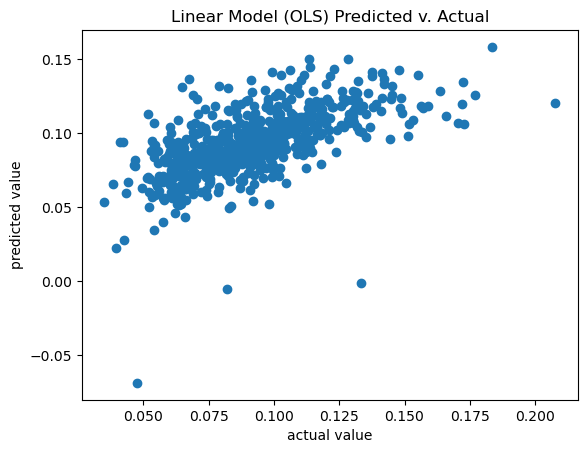

rmse: 0.021302389976575745


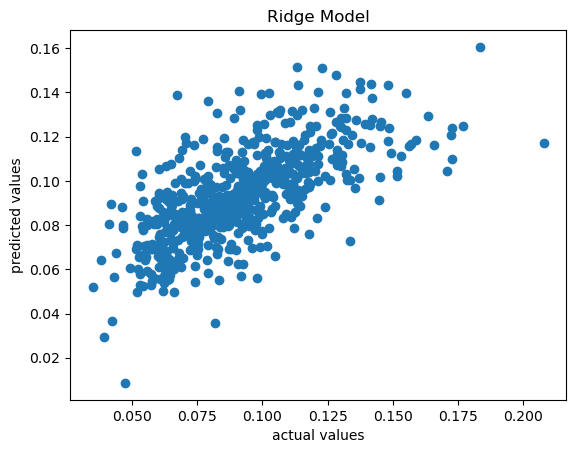

rmse: 0.019621248768205354


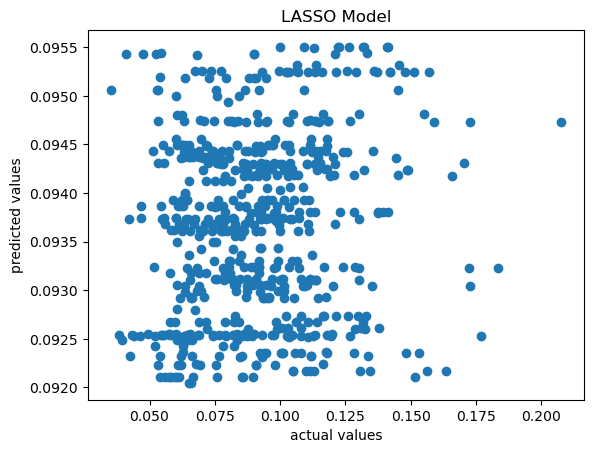

rmse: 0.026013508613541243


In [25]:
#
# Predict on validation data
#-----------
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))


# using the validation dataset and the trained model, predict the number of riders 
lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lin_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

print('rmse:',rmse(lin_pred, y_validate))

# use the model to make predictions
ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

print('rmse:',rmse(ridge_pred, y_validate))


# use the model to make predictions
lasso_pred = lasso_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, lasso_pred)

# add title and labels
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

print('rmse:',rmse(lasso_pred, y_validate))


### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

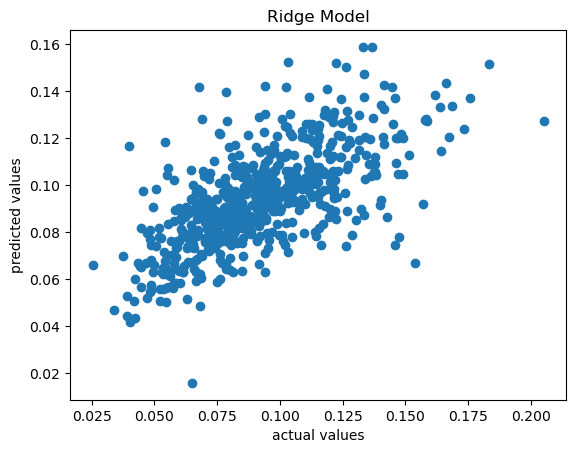

rmse: 0.02082412484718248
RMSE: 0.02082412484718248
R^2 (using sklearn.metrics): 0.4291233042831323
R^2 (using model.score): 0.4291233042831323


In [26]:
#
# Predict using your best model
#-----------
#
# Predict on validation data
#-----------
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

# use the model to make predictions
ridge_pred = ridge_model.predict(X_test)

# plot the predictions
plt.scatter(y_test, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

print('rmse:',rmse(ridge_pred, y_test))
print('RMSE:', rmse(ridge_pred, y_test))
print('R^2 (using sklearn.metrics):', r2_score(y_test, ridge_pred))
print('R^2 (using model.score):', ridge_model.score(X_test, y_test))

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [27]:
#
# Run cross-validation
#-----------
#
# RIDGE 
#-----------
# We will run 9*2*4 = 72 tests, each with 3-fold cross validation

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_validate))


{'alpha': 0.9, 'fit_intercept': True, 'solver': 'auto'}
Best CV R^2: 0.4806436079602265
Validation R^2: 0.4296487199254647
Validation RMSE 0.019655066474935576


## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

In [28]:
# **YOUR ANSWER HERE**...
# The bias issue occurs when models underfit because your models are trained on
# dimensionality that is potentially too low, with very low model complexity. 
# When this happens,
# our models aren't complex enough to have accurate predictions.
# The variance issue happens when model complexity is so high
# that our models are not able to properly adapt when they see new data, meaning that
# overfitting is occurring.
# In machine learning, it's important to find a middle-ground of dimensionality, so that
# our models aren't overfitting, but they're still complex enough to make accurate
# predictions

2. Define overfitting, and why it matters for machine learning. How can we address it?

In [29]:
# **YOUR ANSWER HERE**...
# Overfitting is when models are overly sensitive to random noise, 
# idiosyncracies, or outliers in the training dataset. When overfitting occurs,
# models do not perform well or do not generalize when they try to predict
# novel test data.
# To address overfitting, you can shrink the beta coefficients using methods such as
# ridge regression or Lasso regression, which handle multicollinearity problems.
# Using these aforementioned methods will help reduce the dimensionality of the data,
# meaning that the models are able to generalize to other dataset shapes.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

# **YOUR ANSWER HERE**...

# Compared the the Midwestern intercept, there are slightly higher rates of diabetes in the West and the Northeast.
# The most marked difference in diabetes rates was found in the South and the Southeast, where the Ridge model found that the
# predicted coefficients for diabetes scores were about twice as high as their West/Northeastern counterparts.
# 
# Our model also found that with an increasing ratio of males to females above age 65, the rate of diabetes increases in the community, suggesting
# that males, at least above age 65, are more likely to get diabetes. 
# Based on these findings, the recommendation would be for the pilot program to prioritize the south and southeast regions for implementation. In addition, older populations, specifically men over the age of 65 should be taken into consideration.
# At this time we'd be a bit hesitant to deploy this model in the real-world as our sample is a 2017 pre-pandemic sample. We'd want to first see if predictions change in a sample taken from recent years. In addition, when we take more than regions into account a more complicated story is presented of what populations to prioritize. Further investigation is needed before implementing a pilot program. 
#
